## Loading libs

In [27]:
import pandas as pd
from os import listdir
from os.path import isfile, join

dir = 'final/'
results_fps = [f for f in listdir(dir) if isfile(join(dir, f))]
print(len(results_fps))
results_fps

36


['Burger_etal_aucbandit_BiTRRT.csv',
 'Burger_etal_aucbandit_BKPIECE.csv',
 'Burger_etal_aucbandit_RRTConnect.csv',
 'Burger_etal_default.csv',
 'Burger_etal_gp_BiTRRT.csv',
 'Burger_etal_gp_BKPIECE.csv',
 'Burger_etal_gp_RRTConnect.csv',
 'Burger_etal_ompl.csv',
 'Burger_etal_rand_BiTRRT.csv',
 'Burger_etal_rand_BKPIECE.csv',
 'Burger_etal_rand_RRTConnect.csv',
 'Burger_etal_rf_BiTRRT.csv',
 'Burger_etal_rf_BKPIECE.csv',
 'Burger_etal_rf_RRTConnect.csv',
 'Burger_etal_smac_BiTRRT.csv',
 'Burger_etal_smac_BKPIECE.csv',
 'Burger_etal_smac_RRTConnect.csv',
 'Burger_etal_tpe_BiTRRT.csv',
 'Burger_etal_tpe_BKPIECE.csv',
 'Burger_etal_tpe_RRTConnect.csv',
 'Cano_etal_aucbandit_BKPIECE.csv',
 'Cano_etal_aucbandit_RRTConnect.csv',
 'Cano_etal_default.csv',
 'Cano_etal_gbrt_BKPIECE.csv',
 'Cano_etal_gbrt_RRTConnect.csv',
 'Cano_etal_gp_BKPIECE.csv',
 'Cano_etal_gp_RRTConnect.csv',
 'Cano_etal_ompl.csv',
 'Cano_etal_rand_BKPIECE.csv',
 'Cano_etal_rand_RRTConnect.csv',
 'Cano_etal_rf_BKPIECE.csv

In [20]:
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline


def factor_plot(fps, planner_select, planner, modes=None):
    fps = fps.copy()
    elapsed_time = np.linspace(0, 7200, 500)
    default_fn = planner_select+'_default.csv'
    default_df = pd.read_csv(join(dir, default_fn), index_col=False)
    default = float(
        default_df[(default_df['planner'].str.contains(planner))]['t_avg_plan_time'])
    default_df = pd.DataFrame(
        {'elapsed_time': elapsed_time, 'default': default})
    default_df['default'] = default/default_df['default']
    plt.plot('elapsed_time', 'default', data=default_df)

    ompl_fn = planner_select+'_ompl.csv'
    ompl_df = pd.read_csv(join(dir, ompl_fn), index_col=False)
    ompl = float(
        ompl_df[(ompl_df['planner'].str.contains(planner))]['t_avg_plan_time'])
    ompl_df = pd.DataFrame({'elapsed_time': elapsed_time, 'ompl': ompl})
    ompl_df['ompl'] = default/ompl_df['ompl']
    plt.plot('elapsed_time', 'ompl', data=ompl_df)

    # Planner select filepaths
    speed_up_df = []       
    for f in fps:
        if planner_select in f:
            if not any(x in f for x in ['default', 'ompl']):
                # f = <planner_select>_<mode>_<planner>.csv
                fn = f.split('_')
                planner_fn = fn[-1].split('.')[-2]
                mode = fn[2]
                
                if (modes != None) and (mode not in modes):
                    fps.remove(f)
                else:
                    # Filtering fns for selected planner
                    if re.search(planner_fn, planner, re.IGNORECASE):
                       # print(f)
                        mode_df = pd.read_csv(join(dir, f), index_col=False)
                        # Remove everything slower than ompl baseline
                        # mode_df.drop(mode_df[mode_df.loss >= ompl].index, inplace=True)
                        max_speed_up = ompl
                        speed_up = list(mode_df['loss'])
                        for idx, loss in enumerate(speed_up):
                            if loss < max_speed_up:
                                max_speed_up = loss
                            else:
                                speed_up[idx] = max_speed_up
                        # Clean up messy time data

                        mode_df = pd.DataFrame(
                            {'elapsed_time': mode_df['elapsed_time'], mode: speed_up})
                        mode_df[mode+'_factor'] = ompl/mode_df[mode]
                        plt.plot('elapsed_time', mode+'_factor', data=mode_df)

    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['legend.loc'] = 'upper right'
    plt.title(planner_select + ' ' + planner)
    plt.xticks([0, 1440, 2880, 4320, 5760, 7200])
    #                     plt.yticks([0.8, 1.6, 2.4, 3.1, 3.9, 4.7])
    plt.xlabel('Time spent exploring solutions (secs)')
    plt.ylabel('Speed up over default (secs)')
    plt.legend()

In [3]:
# ps_fps

In [4]:
# fn= 'Cano_etal_smac_BKPIECE.csv'
# df = pd.read_csv(join(dir, fn))
# df.head()

# last_time_pt = list(df['elapsed_time'])[-1]
# while last_time_pt < 7200:
#     n_trial = list(df['n_trial'])[-1] + 1
#     df_last = df.tail(1).copy()
#     df_last['n_trial'] = n_trial
# #     df_last['elapsed_time'] = last_time_pt + 100
# #     df = pd.concat([df, df_last])
#     df.tail(2).reset_index()

## Speedup Factor Plots

### Cano_etal BKPIECE

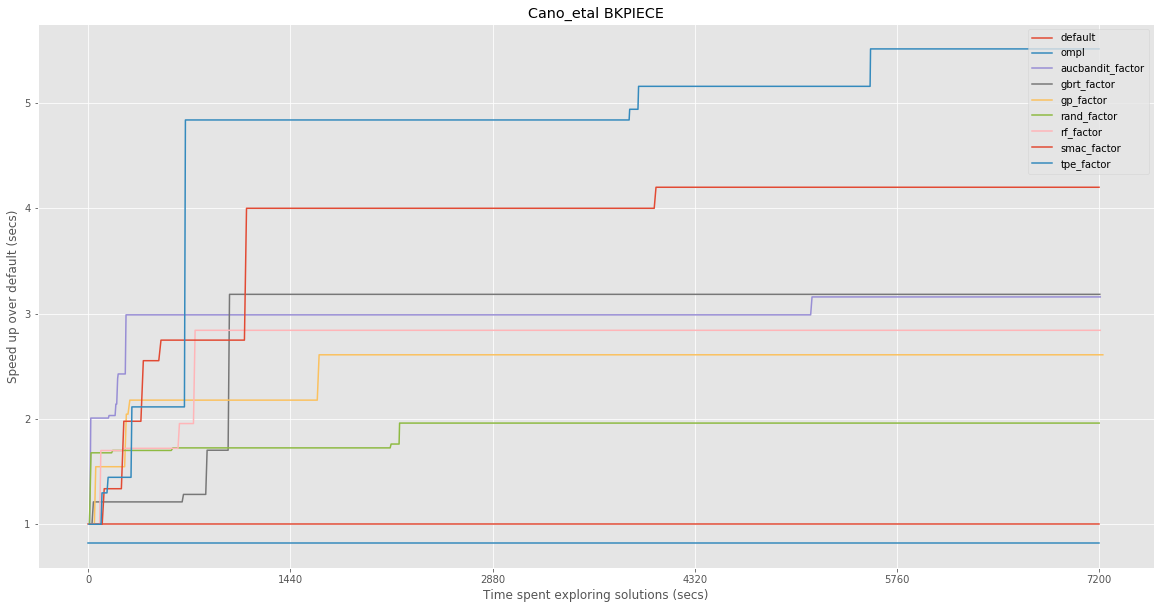

In [28]:
factor_plot(results_fps, 'Cano_etal', 'BKPIECE')

### Cano_etal RRTConnect


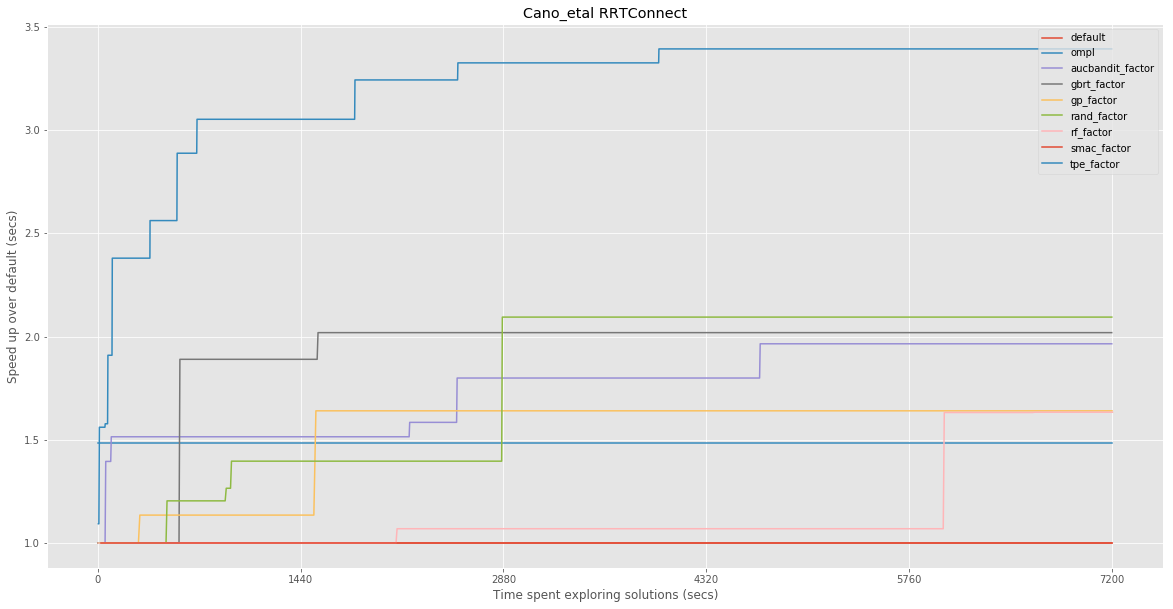

In [23]:
factor_plot(results_fps, 'Cano_etal', 'RRTConnect')

### Burger_etal BKPIECE

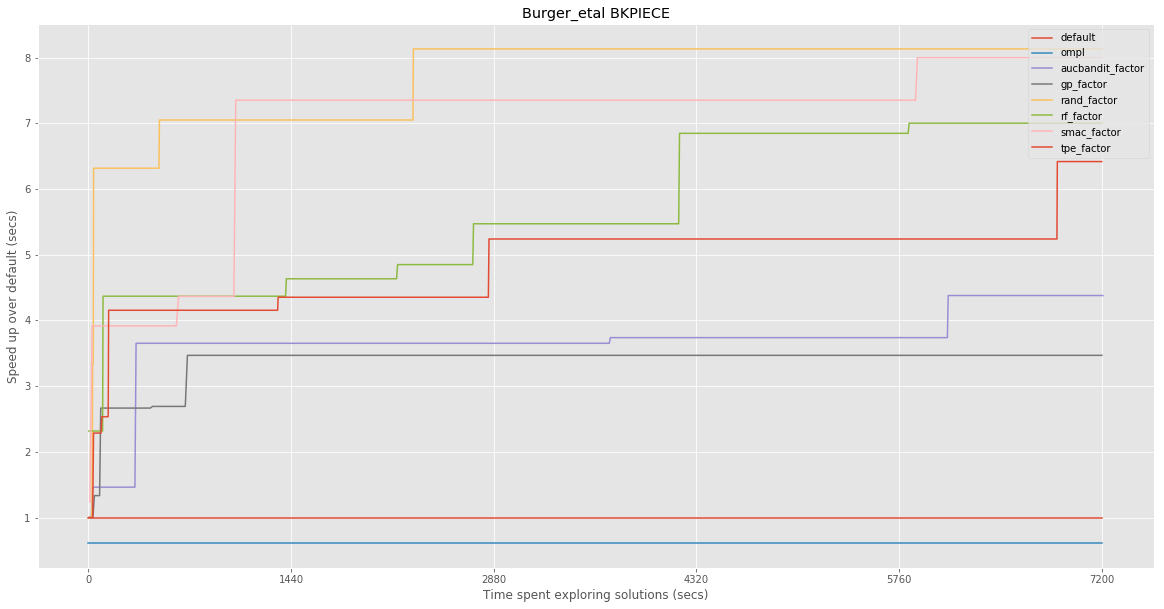

In [24]:
factor_plot(results_fps, 'Burger_etal', 'BKPIECE')

### Burger_etal RRTConnect

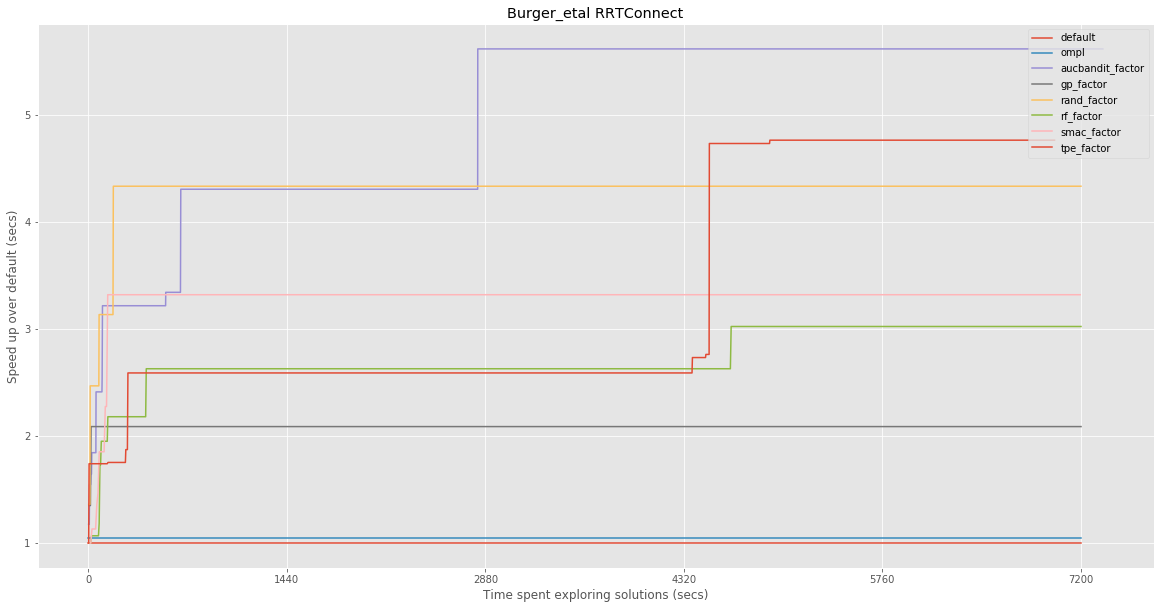

In [25]:
factor_plot(results_fps, 'Burger_etal', 'RRTConnect')

### Burger_etal BiTRRT

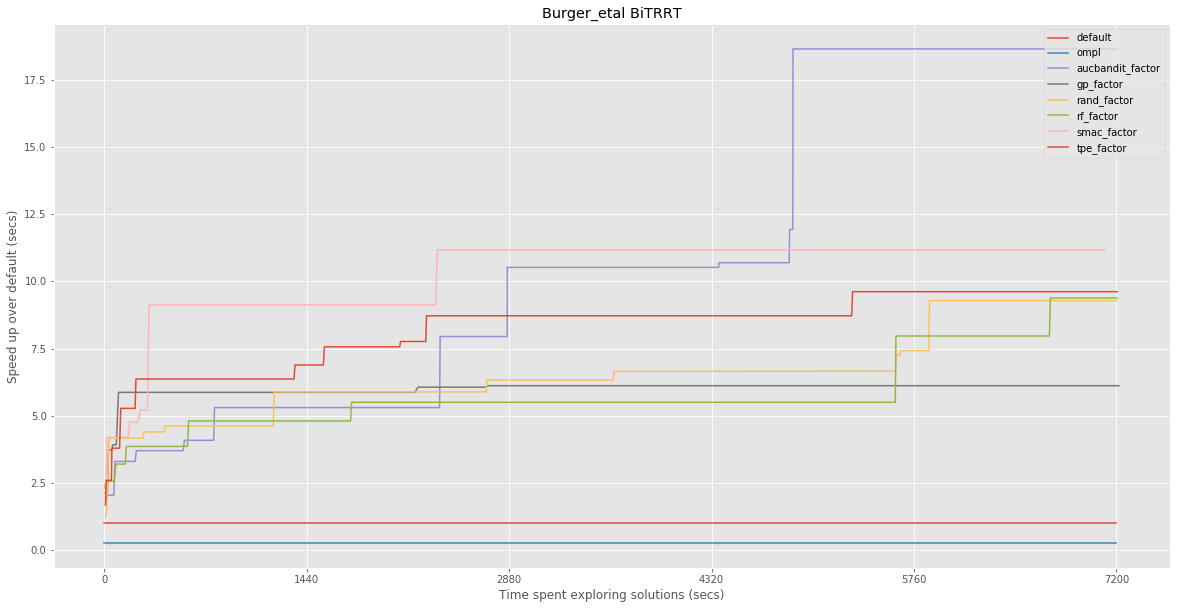

In [26]:
factor_plot(results_fps, 'Burger_etal', 'BiTRRT')